In [1]:
import cv2
import numpy as np
import vtk

In [2]:
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    From https://pyscience.wordpress.com/2014/09/03/ipython-notebook-vtk/
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

In [3]:
# Loads an image and returns a plane object and a camera pointed towards it
def makeImagePlane(imageData) :
    ''' Takes a vtkImageData object and
        returns a plane textured with that image
        and a camera for the background renderer
        http://www.vtk.org/Wiki/VTK/Examples/Cxx/Images/BackgroundImage
        was the basis for this function
    '''
    imageActor = vtk.vtkImageActor()
    
    if vtk.VTK_MAJOR_VERSION <= 5 :
        imageActor.SetInput(imageData)
    else :
        imageActor.SetInputData(imageData)

    origin = imageData.GetOrigin()
    spacing = imageData.GetSpacing()
    extent = imageData.GetExtent()

    camera = vtk.vtkCamera()
    camera.ParallelProjectionOn()

    xc = origin[0] + 0.5*(extent[0] + extent[1])*spacing[0]
    yc = origin[1] + 0.5*(extent[2] + extent[3])*spacing[1]
    yd = (extent[3] - extent[2] + 1)*spacing[1]
    d = camera.GetDistance()
    camera.SetParallelScale(0.5*yd)
    camera.SetFocalPoint(xc,yc,0.0)
    camera.SetPosition(xc,yc,d)

    return camera, imageActor

In [4]:
VtkRenderer = vtk.vtkRenderer()
VtkRenderer.SetBackground(1.0, 1.0, 1.0)

In [5]:
imgDims = (640,480)

# variables for video
cap = cv2.VideoCapture(0)
cap.set(3,imgDims[0])
cap.set(4,imgDims[1])

# variables for rendering
videoFrame = np.zeros(imgDims,np.uint8)

canvasSource = vtk.vtkImageCanvasSource2D()
canvasSource.SetExtent(0, imgDims[0], 0, imgDims[1], 0, 0)
canvasSource.SetScalarTypeToUnsignedChar()
canvasSource.SetNumberOfScalarComponents(3)
canvasSource.SetDrawColor(127, 127, 100)
canvasSource.FillBox(0, imgDims[0], 0, imgDims[1])
canvasSource.SetDrawColor(100, 255, 255)
canvasSource.FillTriangle(10, 10, 25, 10, 25, 25)
canvasSource.SetDrawColor(255, 100, 255)
canvasSource.FillTube(75, 75, 0, 75, 5.0)
canvasSource.Update()
imData = canvasSource.GetOutput()

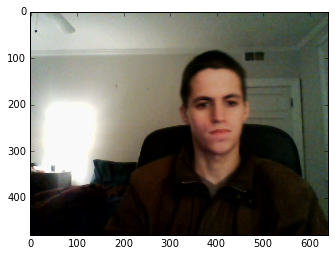

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
ret, frame = cap.read()
rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
imgplot = plt.imshow(rgb)

In [11]:
imData = vtk.vtkImageData()
imData.SetDimensions(imgDims[0], imgDims[1],1) #set dimensions as necessary
imData.SetOrigin(0,0,0) #set origin as necessary
imData.SetSpacing(1, 1, 1) #set spacing as necessary
if vtk.VTK_MAJOR_VERSION <= 5:
    imData.SetNumberOfScalarComponents(3)
    imData.SetScalarTypeToUnsignedChar()
    imData.Update()
else:
    imData.AllocateScalars(vtk.VTK_UNSIGNED_CHAR, 3)

In [12]:
from vtk.util import numpy_support
VTK_data = numpy_support.numpy_to_vtk(num_array=rgb[::-1].ravel(),deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
VTK_data.SetNumberOfComponents(3)
print dir(VTK_data)
print VTK_data.GetDataSize(),640*480*3
print imData.GetNumberOfScalarComponents()
print imData.GetDimensions()
imData.GetPointData().SetScalars(VTK_data)
print imData.GetNumberOfScalarComponents()

['AbstractArray', 'AddObserver', 'Allocate', 'BreakOnError', 'COMPONENT_RANGE', 'ClearLookup', 'CopyComponent', 'CopyComponentNames', 'CopyInformation', 'CreateArray', 'CreateDataArray', 'CreateDefaultLookupTable', 'DISCRETE_VALUES', 'DISCRETE_VALUE_SAMPLE_PARAMETERS', 'DataArray', 'DataArrayTemplate', 'DataChanged', 'DebugOff', 'DebugOn', 'DeepCopy', 'ExportToVoidPointer', 'FastDelete', 'FastDownCast', 'FillComponent', 'GUI_HIDE', 'GetActualMemorySize', 'GetAddressAsString', 'GetArrayType', 'GetClassName', 'GetCommand', 'GetComponent', 'GetComponentName', 'GetData', 'GetDataSize', 'GetDataType', 'GetDataTypeAsString', 'GetDataTypeMax', 'GetDataTypeMin', 'GetDataTypeRange', 'GetDataTypeSize', 'GetDataTypeValueMax', 'GetDataTypeValueMin', 'GetDebug', 'GetElementComponentSize', 'GetGlobalWarningDisplay', 'GetInformation', 'GetLookupTable', 'GetMTime', 'GetMaxDiscreteValues', 'GetMaxId', 'GetMaxNorm', 'GetName', 'GetNumberOfComponents', 'GetNumberOfComponentsMaxValue', 'GetNumberOfCompone

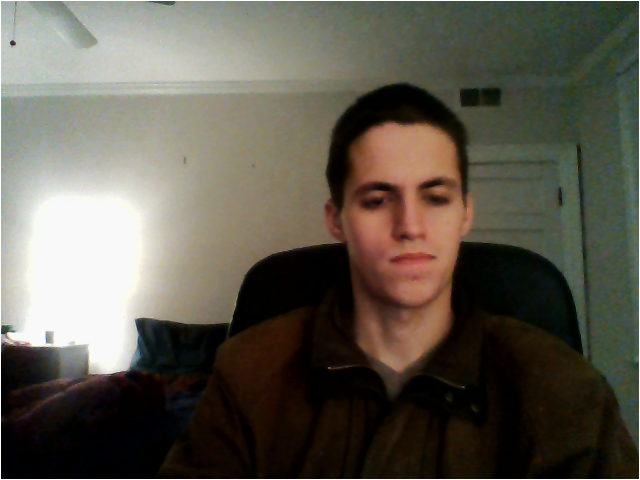

In [9]:
camera, actor = makeImagePlane(imData)
VtkRenderer.AddActor(actor)
VtkRenderer.SetActiveCamera(camera)
vtk_show(VtkRenderer, width=imgDims[0],height=imgDims[1])